In [57]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time
from astropy import units as u
from scipy import stats
from dust_extinction.parameter_averages import F99
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in spectrum of interest:

In [46]:
recx = fits.getdata('./RECX1/ADP.2017-06-02T22:54:12.076.fits')
hdr = fits.getheader('./RECX1/ADP.2017-06-02T22:54:12.076.fits')

In [40]:
fitstable = fits.open('./RECX1/ADP.2017-06-02T22:54:12.076.fits')[1].data
wv = fitstable[0][0]
fl = fitstable[0][1]
flerr = fitstable[0][2]

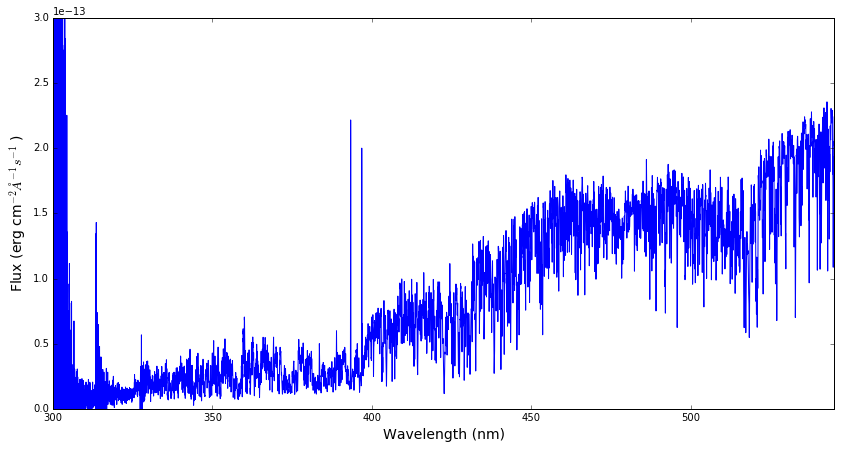

In [50]:
plt.figure(figsize=(14,7))
plt.plot(wv, fl)
plt.ylim(0,3e-13)
plt.xlim(300,545)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

## Testing the R5150 spectral index first:

In [54]:
F_5100 = np.sum(fl[(wv > 495.0) & (wv < 515.0)])
F_5100
F_4650 = np.sum(fl[(wv > 460.0) & (wv < 470.0)]) 
F_4650


7.300179991759359e-11

In [56]:
slope

2.0738754306185728e-13

In [60]:
y = np.concatenate([fl[(wv > 540.0) & (wv < 550.0)],fl[(wv > 460.0) & (wv < 470.0)]])
x = np.concatenate([wv[(wv > 540.0) & (wv < 550.0)],wv[(wv > 460.0) & (wv < 470.0)]])

In [62]:
slope, intercept, r_val, p_val, std_err = stats.linregress(x,y)

In [63]:
slope

6.769473253971424e-16

In [109]:
F_5100 = np.median(fl[(wv > 505.0) & (wv < 515.0)]) # 100 angstroms-wide
F_4650 = np.median(fl[(wv > 460.0) & (wv < 470.0)]) 

# perform a linear regression to fit the expect fluxes over this region - compensates for extinction
y = np.concatenate([fl[(wv > 460.0) & (wv < 470.0)], fl[(wv > 540.0) & (wv < 550.0)]])
x = np.concatenate([wv[(wv > 460.0) & (wv < 470.0)], wv[(wv > 540.0) & (wv < 550.0)]])
slope, intercept, r_val, p_val, std_err = stats.linregress(x,y)

Fline_4650 = np.median(slope*np.linspace(460,470,100) + intercept)
Fline_5100 = np.median(slope*np.linspace(505,515,100) + intercept)

R5150 = (F_5100/F_4650) * (Fline_4650/Fline_5100)
R5150

0.7653918012992242

(8e-14, 2.4e-13)

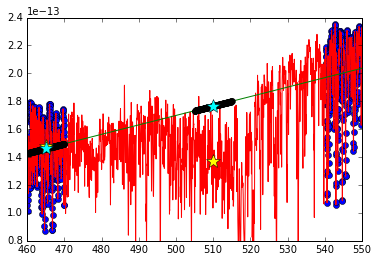

In [103]:
plt.plot(x,y,'o')
x_arr = np.linspace(460,550,1000)
plt.plot(wv, fl,'r')
plt.plot(x_arr, slope*x_arr + intercept)

plt.plot(np.linspace(505,515,100), slope*np.linspace(505,515,100) + intercept, 'ko')
plt.plot(np.linspace(460,470,100), slope*np.linspace(460,470,100) + intercept, 'ko')

plt.plot(510, F_5100, '*', c='yellow', ms=14)
plt.plot(465, F_4650, '*', c='yellow', ms=14)

plt.plot(510, Fline_5100, '*', c='cyan', ms=14)
plt.plot(465, Fline_4650, '*', c='cyan', ms=14)


plt.xlim(460,550)
plt.ylim(0.8e-13, 2.4e-13)

In [108]:
# convert to spectral type? if M0 = 0?
-29.7 + 28.3*(1/R5150)

7.274527231624116

## New spectral index: TiO6800

In [115]:
recx_opt = fits.getdata('./RECX1/ADP.2017-06-02T22:54:12.499.fits')
fitstable_opt = fits.open('./RECX1/ADP.2017-06-02T22:54:12.499.fits')[1].data
wv_opt = fitstable_opt[0][0]
fl_opt = fitstable_opt[0][1]
flerr_opt = fitstable_opt[0][2]

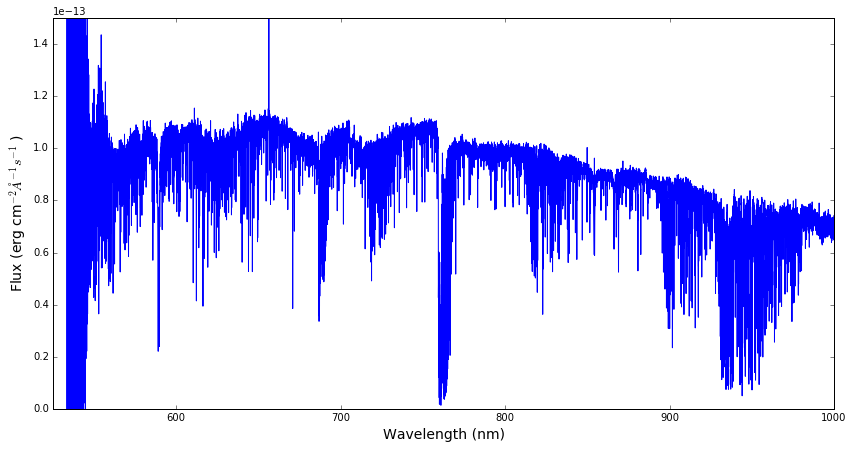

In [119]:
plt.figure(figsize=(14,7))
plt.plot(wv_opt, fl_opt)
plt.ylim(0,1.5e-13)
plt.xlim(525,1000)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

In [121]:
cont = np.median(np.concatenate([fl_opt[(wv_opt > 660.0) & (wv_opt < 666.0)], fl_opt[(wv_opt > 699.0) & (wv_opt < 705.0)]]))
band = np.median(fl_opt[(wv_opt > 675.0) & (wv_opt < 690.0)])

In [126]:
x = cont/band
x

1.0667873140378648

In [125]:
-15.37 + 19.77*x

5.720385198528588

## NIR arm:

In [ ]:
recx_nir = fits.getdata('./RECX1/ADP.2017-06-02T22:54:12.474.fits')
fitstable_nir = fits.open('./RECX1/ADP.2017-06-02T22:54:12.474.fits')[1].data
wv_nir = fitstable_nir[0][0]
fl_nir = fitstable_nir[0][1]
flerr_nir = fitstable_nir[0][2]

## Spectral typing via indices

In [ ]:
def spindexcalc(wv, fl, spindex):
    """
    spindexcalc
    ----------
    
    Calculates optical spectral indices for pre-main sequence stars following the 
    methodology of Herczeg & Hillenbrand (2014).
    
    R5150: Used to type earlier than M0 but later than G, based on the MgH band strength.
           Due to onset of Ti absorbing species in M-types, this does not work beyond M0.5.
    TiO6250: 
    TiO6800:
        
    Inputs
    ----------
    wv         : (array) input wavelength in nm
    fl         : (array) input flux in arbitrary units (as these are all ratios)
    spindex    : (string) requested spectral index. Can be of the following types:
                            R5150,  
  
    Returns
    ----------
    indexval   : (float) index value
    spty       : (string) spectral type 
     
    Dependents
    ----------
    scipy.stats.linregress
    """
    
    if spindex == 'R5150':
        F_5100 = np.median(fl[(wv > 495.0) & (wv < 515.0)]) # 100 angstroms-wide
        F_4650 = np.median(fl[(wv > 460.0) & (wv < 470.0)]) 
        
        # perform a linear regression to fit the expect fluxes over this region - compensates for extinction
        y = np.concatenate([fl[(wv > 540.0) & (wv < 550.0)],fl[(wv > 460.0) & (wv < 470.0)]])
        x = np.concatenate([wv[(wv > 540.0) & (wv < 550.0)],wv[(wv > 460.0) & (wv < 470.0)]])
        slope, intercept, r_val, p_val, std_err = stats.linregress(x,y)
        
        Fline_4650 = np.median(slope*np.linspace(460,470,100) + intercept)
        Fline_5100 = np.median(slope*np.linspace(505,515,100) + intercept)
        R5150 = (F_5100/F4650) * (Fline_4650/Fline_5100)
        
        indexval = R5150
        
    if spindex == 'TiO6800':
        cont = np.median(np.concatenate([fl[(wv > 660.0) & (wv < 666.0)], fl[(wv > 699.0) & (wv < 705.0)]]))
        
    return indexval

## Extinction treatment:

In [ ]:
ext = F99(Rv=3.1) 
spectrum_noext = fxout*ext.extinguish(wavelength_object*u.nm, Av=2.7)